In [147]:
## Import Libraries

import astropy as ap
import astropy.units as u
import astropy.wcs as wcs
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import photutils
import scipy as sci
import sympy as sp

import csv
import os
import sys

from astropy import units as u
from astropy.convolution import Gaussian2DKernel
from astropy.io import fits
from astropy.table import QTable, Table, Column
from astropy.visualization import astropy_mpl_style
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import SqrtStretch

from datetime import datetime

from IPython.display import display_html

from numpy import format_float_scientific as sci

from photutils import detect_sources
from photutils import source_properties
from photutils import EllipticalAperture

from scipy import spatial

#plt.style.use(astropy_mpl_style)
%matplotlib inline
#mpl.use("pgf")
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "pgf.preamble": [
         "\\usepackage{units}",          # load additional packages
         "\\usepackage{metalogo}",
         "\\usepackage{unicode-math}",   # unicode math setup
         r"\setmathfont{xits-math.otf}",
         r"\setmainfont{DejaVu Serif}",  # serif font via preamble
         ]
})

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000

In [23]:
def createFolder(directory): ##https://gist.github.com/keithweaver/562d3caa8650eefe7f84fa074e9ca949
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

## Part One

In [3]:

# The columns in this table are: (these aren't the actual column names)

# (1) galaxy name
# (2) ratio of Hbeta flux to Halpha flux
# (3) note on Hbeta flux ratio
# (4) ratio of [OIII] 5007 flux to Halpha flux
# (5) note on [OIII] flux ratio
# (6) ratio of [OI] 6300 flux to Halpha flux
# (7) note on [OI] flux ratio
# (8) ratio of [NII] 6583 flux to Halpha flux
# (9) note on [NII] flux ratio
# (10) log of (the observed Halpha flux in units of erg/cm^2/s)
# (11) note on the log of the observed Halpha flux
# (12) log of (the Halpha luminosity in units of erg/s)
# (13) note on the log of the Halpha luminosity
# (14) equivalent width of the Halpha line (units of Angstroms)
# (15) note on the Halpha equivalent width
# (16) FWHM of the [NII] 6583 line (units of km/s)
# (17) note on the [NII] line width

# The notes mean:

#  L = 3 sigma lower limit
#  u = 3 sigma upper limit
#  s = line strength obtained by scaling the intensity of another line
#  b = value with substantial uncertainty of +/- 30-50%
#  c = value with very substantial uncertainty of +/- 100%

galaxOg = pd.read_csv("./dataTable1.csv",sep=',')
#df['[NII]6583 FWHM note']
#df.where(df.notnull(), None,inplace=True)
#galaxOG['[NII]6583 FWHM note'].fillna('', inplace=True)
galaxOg.replace(r'^\s*$', np.nan, regex=True,inplace=True)
galaxOg.replace(['u ', 'c ', 'b ', 's '], ['u', 'c', 'b', 's'],inplace=True)
display(galaxOg)

,galaxy,Hbeta,Hbeta note,[OIII]5007,[OIII]5007 note,[OI]6300,[OI]6300 note,[NII]6583,[NII]6583 note,log Halpha flux,log Halpha flux note,log Halpha lum,log Halpha lum note,Halpha width,Halpha width note,[NII]6583 FWHM,[NII]6583 FWHM note
0,IC 10,0.08,NaN,0.35,NaN,0.006,u,0.04,NaN,-12.72,NaN,37.59,NaN,1743.64,NaN,70,NaN
1,IC 239,1.47,u,1.47,u,0.590,u,0.59,c,-15.77,cL,36.76,cL,0.81,c,NaN,NaN
2,IC 342,0.13,NaN,0.01,NaN,0.007,NaN,0.45,NaN,-12.67,L,38.36,L,41.49,NaN,145,NaN
3,IC 356,0.1,c,0.24,NaN,0.110,NaN,1.68,NaN,-14.40,L,38.19,L,1.28,NaN,311,NaN
4,IC 467,0.17,NaN,0.07,NaN,0.058,NaN,0.44,NaN,-14.65,L,38.30,L,6.76,NaN,104,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,NGC 7817,0.18,NaN,0.29,NaN,0.014,NaN,0.39,NaN,-13.25,NaN,39.83,NaN,70.12,NaN,133,NaN
414,UGC 3714,0.21,NaN,0.07,NaN,0.041,NaN,0.46,NaN,-13.66,NaN,39.64,NaN,10.66,NaN,195,NaN
415,UGC 3828,0.2,NaN,0.06,NaN,0.021,NaN,0.39,NaN,-13.36,NaN,40.06,NaN,31.35,NaN,199,NaN
416,UGC 4028,0.24,NaN,0.13,NaN,0.036,NaN,0.47,NaN,-13.75,NaN,39.77,NaN,14.22,NaN,194,NaN


In [4]:
galaxOgFilt = galaxOg.query(" `Hbeta` == `Hbeta` ")
galaxOgFilt = galaxOgFilt.query(" `[OIII]5007` == `[OIII]5007` ")
galaxOgFilt = galaxOgFilt.query(" `[NII]6583` == `[NII]6583` ")
c = str('c')
b = str('b')
sb = str('sb')
galaxOgFilt = galaxOgFilt.query(" `Hbeta note` != @c ")
galaxOgFilt = galaxOgFilt.query(" `[OIII]5007 note` != @c ")
galaxOgFilt = galaxOgFilt.query(" `[NII]6583 note` != @c ")

galaxOgFilt = galaxOgFilt.query(" `Hbeta note` != @b")
galaxOgFilt = galaxOgFilt.query(" `[OIII]5007 note` != @b")
galaxOgFilt = galaxOgFilt.query(" `[NII]6583 note` != @b")

galaxOgFilt = galaxOgFilt.query(" `Hbeta note` != @sb")
galaxOgFilt = galaxOgFilt.query(" `[OIII]5007 note` != @sb")
galaxOgFilt = galaxOgFilt.query(" `[NII]6583 note` != @sb")
#galaxOgFilt = galaxOgFilt.reset_index()
display(galaxOgFilt)

,galaxy,Hbeta,Hbeta note,[OIII]5007,[OIII]5007 note,[OI]6300,[OI]6300 note,[NII]6583,[NII]6583 note,log Halpha flux,log Halpha flux note,log Halpha lum,log Halpha lum note,Halpha width,Halpha width note,[NII]6583 FWHM,[NII]6583 FWHM note
0,IC 10,0.08,NaN,0.35,NaN,0.006,u,0.04,NaN,-12.72,NaN,37.59,NaN,1743.64,NaN,70,NaN
2,IC 342,0.13,NaN,0.01,NaN,0.007,NaN,0.45,NaN,-12.67,L,38.36,L,41.49,NaN,145,NaN
4,IC 467,0.17,NaN,0.07,NaN,0.058,NaN,0.44,NaN,-14.65,L,38.30,L,6.76,NaN,104,NaN
6,IC 1727,0.19,NaN,0.45,NaN,0.160,NaN,0.93,NaN,-14.21,NaN,37.69,NaN,2.12,NaN,176,NaN
7,IC 2574,0.18,NaN,0.04,NaN,0.025,u,0.07,NaN,-14.19,NaN,36.95,NaN,641,NaN,67,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,NGC 7817,0.18,NaN,0.29,NaN,0.014,NaN,0.39,NaN,-13.25,NaN,39.83,NaN,70.12,NaN,133,NaN
414,UGC 3714,0.21,NaN,0.07,NaN,0.041,NaN,0.46,NaN,-13.66,NaN,39.64,NaN,10.66,NaN,195,NaN
415,UGC 3828,0.2,NaN,0.06,NaN,0.021,NaN,0.39,NaN,-13.36,NaN,40.06,NaN,31.35,NaN,199,NaN
416,UGC 4028,0.24,NaN,0.13,NaN,0.036,NaN,0.47,NaN,-13.75,NaN,39.77,NaN,14.22,NaN,194,NaN


In [5]:
#subtest = test[test['Hbeta note'] == 'u ']
#galaxOgFilt.replace(['u ', 'c ', 'b ', 's '], ['u', 'c', 'b', 's'],inplace=True)
#display(subtest)
#galaxOgFilt['Hbeta note'].unique()

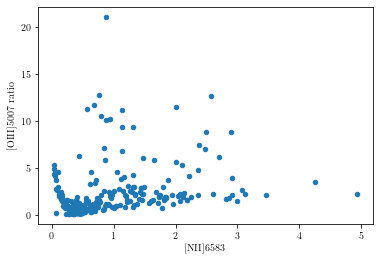

In [6]:
galaxOgFilt['[OIII]5007 ratio'] = galaxOgFilt['[OIII]5007'].astype(np.float) / galaxOgFilt['Hbeta'].astype(np.float)
#display(galaxOgFilt['[OIII]5007 ratio'])
#galaxOgFilt['[NII]6583 ratio'] = galaxOgFilt['[NII]6583'] / galaxOgFilt['Hbeta']

galaxOgFilt.plot(kind='scatter', x = '[NII]6583', y = '[OIII]5007 ratio')
#plt.show()

## Part Two

In [7]:
## For the files: 
## Column 1: Rest Frame Wavelength (angstrom)
## Column 2: Wavelength Flux Density ( 10^-15 erg/cm^2/s/angstrom )
s1 = pd.read_csv('./spectrum1.txt', sep = '    ',header=None, engine = "python")
s1.columns = ["Rest Wavelength","Flux Density"]
# display(s1)

s2 = pd.read_csv('./spectrum2.txt', sep = '    ',header=None, engine = "python")
s2.columns = ["Rest Wavelength","Flux Density"]
# display(s2)

s3 = pd.read_csv('./spectrum3.txt', sep = '    ',header=None, engine = "python")
s3.columns = ["Rest Wavelength","Flux Density"]
# display(s3)

s4 = pd.read_csv('./spectrum4.txt', sep = '    ',header=None, engine = "python")
s4.columns = ["Rest Wavelength","Flux Density"]
# display(s4)

s5 = pd.read_csv('./spectrum5.txt', sep = '    ',header=None, engine = "python")
s5.columns = ["Rest Wavelength","Flux Density"]
# display(s5)

s6 = pd.read_csv('./spectrum6.txt', sep = '    ',header=None, engine = "python")
s6.columns = ["Rest Wavelength","Flux Density"]
# display(s6)

s7 = pd.read_csv('./spectrum7.txt', sep = '    ',header=None, engine = "python")
s7.columns = ["Rest Wavelength","Flux Density"]
# display(s7)

s8 = pd.read_csv('./spectrum8.txt', sep = '    ',header=None, engine = "python")
s8.columns = ["Rest Wavelength","Flux Density"]
# display(s8)

s9 = pd.read_csv('./spectrum9.txt', sep = '    ',header=None, engine = "python")
s9.columns = ["Rest Wavelength","Flux Density"]
# display(s9)

s10 = pd.read_csv('./spectrum10.txt', sep = '    ',header=None, engine = "python")
s10.columns = ["Rest Wavelength","Flux Density"]
# display(s10)

In [8]:
p1 = pd.read_csv('./partner1.txt', sep = '    ',header=None, engine = "python")
p1.columns = ["Rest Wavelength","Flux Density"]
# display(p1)

p2 = pd.read_csv('./partner2.txt', sep = '    ',header=None, engine = "python")
p2.columns = ["Rest Wavelength","Flux Density"]
# display(p2)

p3 = pd.read_csv('./partner3.txt', sep = '    ',header=None, engine = "python")
p3.columns = ["Rest Wavelength","Flux Density"]
# display(p3)

p4 = pd.read_csv('./partner4.txt', sep = '    ',header=None, engine = "python")
p4.columns = ["Rest Wavelength","Flux Density"]
# display(p4)

p5 = pd.read_csv('./partner5.txt', sep = '    ',header=None, engine = "python")
p5.columns = ["Rest Wavelength","Flux Density"]
# display(p5)

p6 = pd.read_csv('./partner6.txt', sep = '    ',header=None, engine = "python")
p6.columns = ["Rest Wavelength","Flux Density"]
# display(p6)

p7 = pd.read_csv('./partner7.txt', sep = '    ',header=None, engine = "python")
p7.columns = ["Rest Wavelength","Flux Density"]
# display(p7)

p8 = pd.read_csv('./partner8.txt', sep = '    ',header=None, engine = "python")
p8.columns = ["Rest Wavelength","Flux Density"]
# display(p8)

p9 = pd.read_csv('./partner9.txt', sep = '    ',header=None, engine = "python")
p9.columns = ["Rest Wavelength","Flux Density"]
# display(p9)

p10 = pd.read_csv('./partner10.txt', sep = '    ',header=None, engine = "python")
p10.columns = ["Rest Wavelength","Flux Density"]
# display(p10)

In [9]:
#display(s1)
#display(p1)

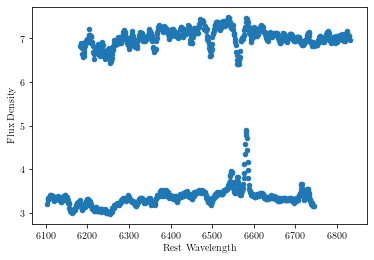

In [10]:
ax1 = s1.plot(kind='scatter', x = 'Rest Wavelength',y='Flux Density')
p1.plot(kind='scatter', x = 'Rest Wavelength',y='Flux Density', ax =ax1)
plt.show()

In [11]:
def pair(pair=0): ## Just takes an int from 1-10 and returns emmission and absorption DataFrames
    if pair == 0:
        return 0, 0
    elif pair == 1:
        gal, part = s1, p1
    elif pair == 2:
        gal, part = s2, p2
    elif pair == 3:
        gal, part = s3, p3
    elif pair == 4:
        gal, part = s4, p4
    elif pair == 5:
        gal, part = s5, p5
    elif pair == 6:
        gal, part = s6, p6
    elif pair == 7:
        gal, part = s7, p7
    elif pair == 8:
        gal, part = s8, p8
    elif pair == 9:
        gal, part = s9, p9
    elif pair == 10:
        gal, part = s10, p10
    return gal,part

In [68]:
def trim(pairNum=0, verbose=False, plot=False, savePlot='none'): ## Trims DataFrames so galaxy pairs have matching range
    gal, part = pair(pairNum)
    if pairNum == 0:
        print('add an argument for the spectrum pair, ya dingus')
        return
    elif pairNum != 10:
        pairStr = str(0)+str(pairNum)
    elif pairNum == 10:
        pairStr = str(pairNum)
    
    #galMax = gal['Rest Wavelength'].max()
    #partMax = part['Rest Wavelength'].max()
    if gal['Rest Wavelength'].max() <= part['Rest Wavelength'].max():
        plusle = gal['Rest Wavelength'].max() ## Max value of spectra emmission lines
        partFilt = part.query('`Rest Wavelength` <= @plusle')
        galFilt = gal.query('`Rest Wavelength` <= @plusle')
        #print('gal.max<part.max')
    elif gal['Rest Wavelength'].max() >= part['Rest Wavelength'].max(): 
        plusle = part['Rest Wavelength'].max() ## Max value of absorption lines
        galFilt = gal.query('`Rest Wavelength` <= @plusle')
        partFilt = part.query('`Rest Wavelength` <= @plusle')
        #print('gal.max>part.max')
    
    #galMin = gal['Rest Wavelength'].min()
    #partMin = part['Rest Wavelength'].min()   
    if gal['Rest Wavelength'].min() >= part['Rest Wavelength'].min():
        minun = gal['Rest Wavelength'].min() ## Min Value of emmission lines
        partFilt = partFilt.query('`Rest Wavelength` >= @minun')
        galFilt = galFilt.query('`Rest Wavelength` >= @minun')
        #print('gal.min>part.min')
    elif gal['Rest Wavelength'].min() <= part['Rest Wavelength'].min():
        minun = part['Rest Wavelength'].min() ## Min Value of partner absorption lines
        galFilt = galFilt.query('`Rest Wavelength` >= @minun')
        partFilt = partFilt.query('`Rest Wavelength` >= @minun')
        #print('gal.min<part.min')
    
    if verbose == True:
        galCut = np.abs(gal.shape[0] - galFilt.shape[0])
        partCut = np.abs(part.shape[0] - partFilt.shape[0])
        galCent = 100*( galCut / gal.shape[0] )
        galCent = np.around(galCent,2)
        partCent = 100*(partCut /part.shape[0])
        partCent = np.around(partCent,2)
        
        print("galaxy pair "+pairStr)
        print("minimum wavelength: ",minun," Angstroms")
        print("maximum wavelength",plusle," Angstroms")
        #print("number of points removed from emission line: ",galCut)
        #print("number of points removed from absorption line: ",partCut)
        print("percent of emission line data points removed: ", galCent,"%")
        print("percent of absorption line data points removed: ", partCent,"%")
        print("number of emission line data points after cut: ",galFilt.shape[0])
        print("number of absorption line data points after cut:",partFilt.shape[0])
        print()
        
    if plot == True:
        tit = str("Flux Density vs. Rest Wavelength \n for Galaxy Pair "+pairStr)
        axTrim = galFilt.plot(
            x ='Rest Wavelength',y='Flux Density', 
            color='orange', label='Emission Line\n Galaxies')
        partFilt.plot(
            x ='Rest Wavelength',y='Flux Density',
            color='blue', label='Absorption Line\n Galaxies',
            title=tit, ax =axTrim)
        if savePlot != 'none':
            createFolder('./galaxyPairPlots/')
            directory = './galaxyPairPlots/'
            
            if savePlot == 'trim':
                #print('saving trimmed wavelength plot...')
                mpl.pyplot.savefig(directory+'trimWavelength'+pairStr+'.png')
                #print('trimmed plot saved')
                plt.show()
            elif savePlot == 'both':
                #print('saving trimmed wavelength plot...')
                mpl.pyplot.savefig(directory+'trimWavelength'+pairStr+'.png')
                #print('trimmed plot saved')
                plt.show()
                plt.clf()
                #print('saving full wavelength plot...')
                axUntrim = gal.plot(
                    x ='Rest Wavelength',y='Flux Density', 
                    color='purple', label='Emission Line\n Galaxies')
                part.plot(
                    x ='Rest Wavelength',y='Flux Density',
                    color='pink', label='Absorption Line\n Galaxies',
                    title=tit+' (Untrimmed)', ax =axUntrim)
                plt.axvline(x=plusle,color='black',linestyle='dashed')
                plt.axvline(x=minun,color='black',linestyle='dashed')
                mpl.pyplot.savefig(directory+'fullWavelength'+pairStr+'.png')
                #print('full wavelength plot saved')
                plt.show()
            else:
                print(str(savePlot)+' is not a valid argument!')
                print('arguments for savePlot (strings): none, trim, both')
        elif savePlot == 'none':
            plt.show()
    if plot == False and savePlot != 'none':
        print('WARNING: Plot will not be saved without adding the argument `plot=True`')
    return galFilt, partFilt


galaxy pair 01
minimum wavelength:  6183.15  Angstroms
maximum wavelength 6743.84  Angstroms
percent of emission line data points removed:  12.44 %
percent of absorption line data points removed:  13.36 %
number of emission line data points after cut:  570
number of absorption line data points after cut: 564



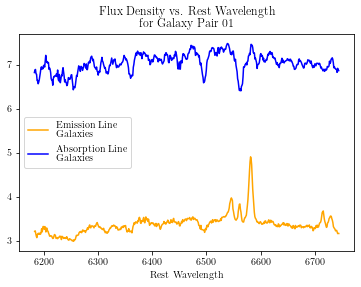

<Figure size 432x288 with 0 Axes>

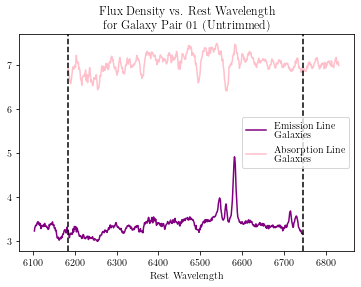

galaxy pair 02
minimum wavelength:  6226.0  Angstroms
maximum wavelength 6738.13  Angstroms
percent of emission line data points removed:  19.97 %
percent of absorption line data points removed:  16.86 %
number of emission line data points after cut:  521
number of absorption line data points after cut: 513



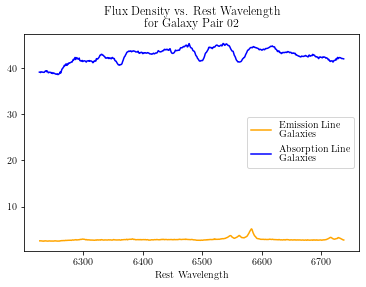

<Figure size 432x288 with 0 Axes>

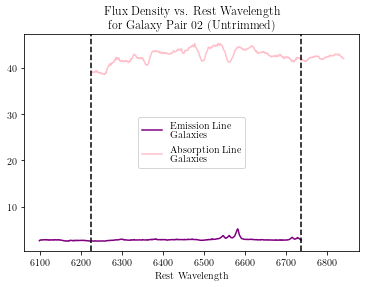

galaxy pair 03
minimum wavelength:  6209.39  Angstroms
maximum wavelength 6810.86  Angstroms
percent of emission line data points removed:  6.35 %
percent of absorption line data points removed:  7.07 %
number of emission line data points after cut:  605
number of absorption line data points after cut: 605



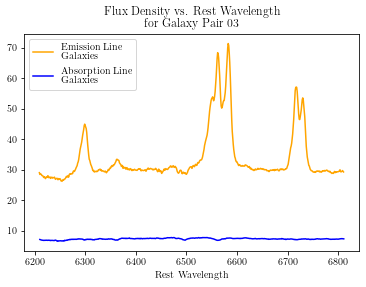

<Figure size 432x288 with 0 Axes>

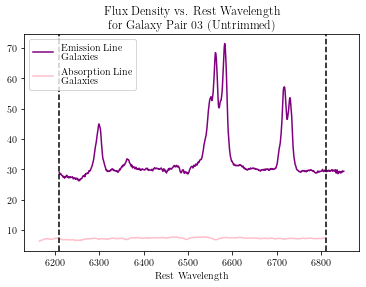

galaxy pair 04
minimum wavelength:  6189.0  Angstroms
maximum wavelength 6827.82  Angstroms
percent of emission line data points removed:  1.08 %
percent of absorption line data points removed:  1.24 %
number of emission line data points after cut:  642
number of absorption line data points after cut: 639



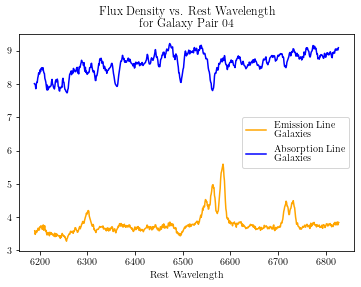

<Figure size 432x288 with 0 Axes>

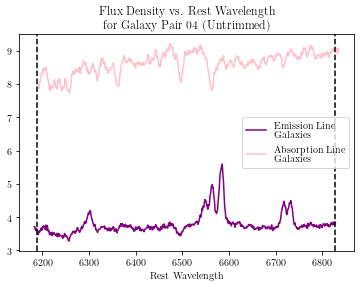

galaxy pair 05
minimum wavelength:  6184.0  Angstroms
maximum wavelength 6800.22  Angstroms
percent of emission line data points removed:  4.45 %
percent of absorption line data points removed:  4.49 %
number of emission line data points after cut:  622
number of absorption line data points after cut: 617



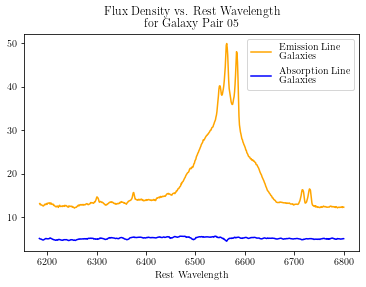

<Figure size 432x288 with 0 Axes>

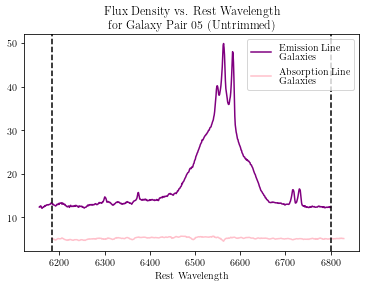

galaxy pair 06
minimum wavelength:  6207.0  Angstroms
maximum wavelength 6823.0  Angstroms
percent of emission line data points removed:  0.0 %
percent of absorption line data points removed:  5.38 %
number of emission line data points after cut:  617
number of absorption line data points after cut: 616



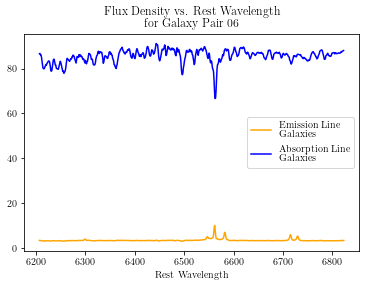

<Figure size 432x288 with 0 Axes>

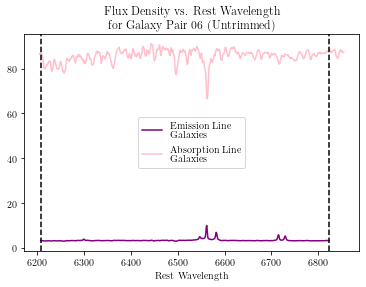

galaxy pair 07
minimum wavelength:  6217.85  Angstroms
maximum wavelength 6819.45  Angstroms
percent of emission line data points removed:  6.5 %
percent of absorption line data points removed:  7.07 %
number of emission line data points after cut:  604
number of absorption line data points after cut: 605



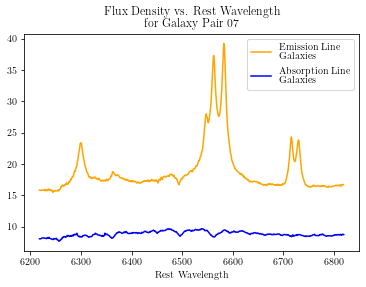

<Figure size 432x288 with 0 Axes>

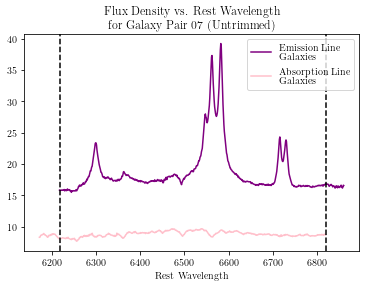

galaxy pair 08
minimum wavelength:  6193.78  Angstroms
maximum wavelength 6834.0  Angstroms
percent of emission line data points removed:  1.08 %
percent of absorption line data points removed:  0.77 %
number of emission line data points after cut:  642
number of absorption line data points after cut: 641



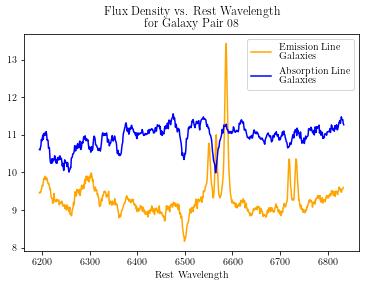

<Figure size 432x288 with 0 Axes>

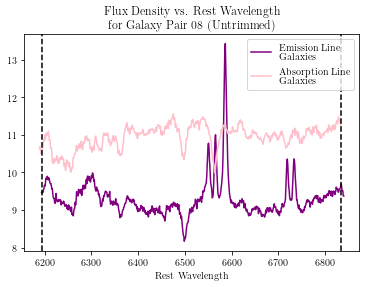

galaxy pair 09
minimum wavelength:  6163.0  Angstroms
maximum wavelength 6805.95  Angstroms
percent of emission line data points removed:  0.15 %
percent of absorption line data points removed:  0.16 %
number of emission line data points after cut:  648
number of absorption line data points after cut: 643



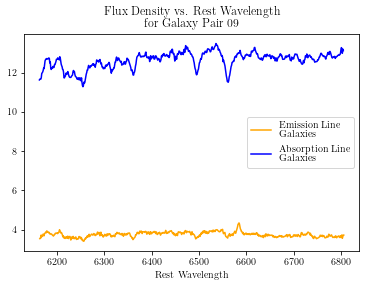

<Figure size 432x288 with 0 Axes>

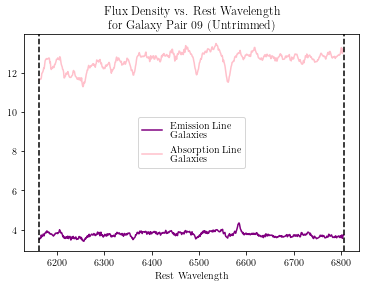

galaxy pair 10
minimum wavelength:  6184.04  Angstroms
maximum wavelength 6826.19  Angstroms
percent of emission line data points removed:  0.92 %
percent of absorption line data points removed:  0.62 %
number of emission line data points after cut:  645
number of absorption line data points after cut: 645



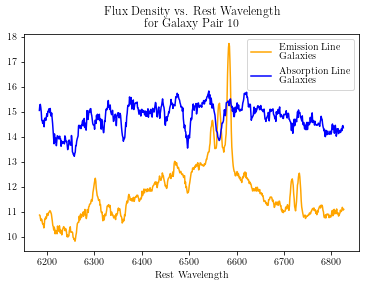

<Figure size 432x288 with 0 Axes>

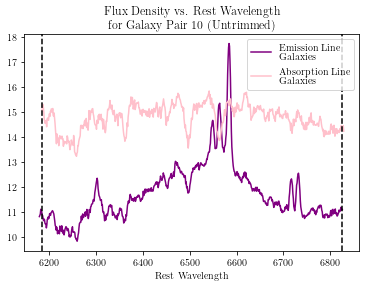

In [42]:
for i in range(1,11):
    trim(pairNum= i ,verbose=True,plot=True,savePlot='both')

In [15]:
s1t, p1t = trim(pairNum=1)
#display(s1t)
s1t['Rest Wavelength'] = s1t['Rest Wavelength']
p1t['Rest Wavelength'] = p1t['Rest Wavelength']
s1tr = s1t.set_index('Rest Wavelength')
p1tr = p1t.set_index('Rest Wavelength')
#display(s1tr)

(570, 1)


In [146]:
min1 = round(s1tr.index.min())
#print(min1)
max1 = round(s1tr.index.max())
#print(max1)
len1 = round(max1-min1)
#print(len(s1tr.index))
#print(len1)
newIndex1 = np.linspace(min1,max1-1,len1)
#print(newIndex1)

interp1s = pd.DataFrame(index=newIndex1)
interp1s.index.name = s1tr.index.name

interp1p = pd.DataFrame(index=newIndex1)
interp1p.index.name = p1tr.index.name
#display(interp1s)

for colname, col in s1tr.iteritems():
    interp1s[colname] = np.interp(newIndex1,s1tr.index,col)
for colname, col in p1tr.iteritems():
    interp1p[colname] = np.interp(newIndex1,p1tr.index,col)
display_side_by_side(p1tr,interp1p)

,Flux Density
Rest Wavelength,
6183.15,6.82180
6184.15,6.87760
6185.14,6.89104
6186.14,6.79389
6187.13,6.78293
6188.13,6.63721
6189.12,6.64122
6190.12,6.56581
6191.12,6.60342


In [107]:
def interpolate(pairNum=0, verbose=False, plot=False, savePlot=False): ## Interpolates pair to 
    ## matching index
    gal, part = trim(pairNum=pairNum)
    if pairNum == 0:
        print('add an argument for the spectrum pair, ya dingus')
        return
    elif pairNum != 10:
        pairStr = str(0)+str(pairNum)
    elif pairNum == 10:
        pairStr = str(pairNum)
    
    galRe = gal.set_index('Rest Wavelength')
    partRe = part.set_index('Rest Wavelength')
    galLength = round(len(galRe.index))
    partLength = round(len(partRe.index))
    if galLength >= partLength:
        minun = round(partRe.index.min())
        plusle = round(partRe.index.max())
    elif galLength <= partLength:
        minun = round(galRe.index.min())
        plusle = round(galRe.index.max())
    
    numPoints = round(abs(plusle-minun))
    newIndex = np.linspace(minun,plusle-1,numPoints) ## need to subtract one from max to keep range correct
    
    galInt = pd.DataFrame(index=newIndex)
    galInt.index.name = galRe.index.name
    
    partInt = pd.DataFrame(index=newIndex)
    partInt.index.name = partRe.index.name
    
    for colname, col in galRe.iteritems():
        galInt[colname] = np.interp(newIndex,galRe.index,col)
    for colname, col in partRe.iteritems():
        partInt[colname] = np.interp(newIndex,partRe.index,col)
    galInt.reset_index(inplace=True)
    partInt.reset_index(inplace=True)
    
    if verbose == True:
        numPointsDiff = abs(galLength - partLength)
        print("galaxy pair "+pairStr)
        print("minimum wavelength: ",minun," Angstroms")
        print("maximum wavelength",plusle," Angstroms")
        if galLength >= partLength:
            print('emission line galaxy has ',numPointsDiff,' more data points than the partner absorption line galaxy')
        elif galLength <= partLength:
            print('emission line galaxy has ',numPointsDiff,' fewer data points than the partner absorption line galaxy')
    if plot == True:
        tit = str('Effects of interpolation for Galaxy Pair '+str(pairStr))
        axGal = gal.plot(
            x ='Rest Wavelength',y='Flux Density', 
            color='purple', label='Original Emission Lines', 
            title=tit, lw=4)
        galInt.plot(
            x ='Rest Wavelength',y='Flux Density',
            color='orange', label='Interpolated Emission Lines',
            ax =axGal)
        part.plot(
            x ='Rest Wavelength',y='Flux Density',
            color='pink', label='Original Absorption Lines', 
            lw=4, ax =axGal)
        partInt.plot(
            x ='Rest Wavelength',y='Flux Density',
            color='blue', label='Interpolated Absorption Lines', 
            ax =axGal)
        if savePlot == True:
            createFolder('./galaxyPairPlots/')
            directory = './galaxyPairPlots/'
            mpl.pyplot.savefig(directory+'interpWavelengths'+pairStr+'.png')
        plt.show()
    if plot == False and savePlot == True:
        print('WARNING: Plot will not be saved without the argument `plot=True`')
    
    return galInt, partInt

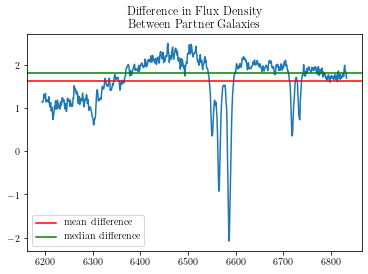

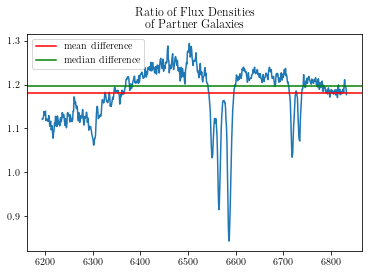

In [157]:
galInt, partInt = interpolate(8)
diff = partInt - galInt
#display(diff)
#display(diff['Flux Density'].mean())
#display(diff['Flux Density'].median())
#display(diff['Flux Density'].std())
print()
frac = abs(partInt/galInt)
# display(frac)
#display(frac['Flux Density'].mean())
#display(frac['Flux Density'].median())
#display(frac['Flux Density'].std())

#diff.plot(x='Rest Wavelength',y='Flux Density',title='Difference in Flux Density \n Between Partner Galaxies')

plt.plot(galInt['Rest Wavelength'],diff['Flux Density'])
plt.title('Difference in Flux Density \n Between Partner Galaxies')
plt.axhline(y=diff['Flux Density'].mean(), label='mean difference',color='red')
plt.axhline(y=diff['Flux Density'].median(), label='median difference',color='green')
plt.legend()
plt.show()

plt.plot(galInt['Rest Wavelength'],frac['Flux Density'])
plt.title('Ratio of Flux Densities \n of Partner Galaxies')
plt.axhline(y=frac['Flux Density'].mean(), label='mean difference',color='red')
plt.axhline(y=frac['Flux Density'].median(), label='median difference',color='green')
plt.legend()
plt.show()